# Machine Learning Project: Key Detection
Authors: Zach Hayes, Matt Gaetano, Max Ivry

Course: CS3540


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

### Gather Training and Testing Data
Data cleaning and feature extraction occured earlier in process. See clean.ipynb

In [18]:
def retrieve_data():
    train_df = pd.read_json("train.json", lines=True)
    #test_df = pd.read_json("test.json", lines=True)

    def combine_equal(df):
        # Combine "tonally equivalent" classes by replacing some labels
        tonal_equ = {
                "A#": "Bb",
                "B#": "C",
                "C#": "Db",
                "D#": "Eb",
                "E#": "F",
                "F#": "Gb",
                "G#": "Ab"
            }
    
        df[['note', 'modality']] = pd.DataFrame(df.target.tolist(), index=df.index)
        df["note"] = df['note'].replace(tonal_equ)
        df["target"] = df[["note", "modality"]].astype(str).apply(' '.join, axis=1)
        df.drop(["note", "modality"], axis=1, inplace=True)

    combine_equal(train_df)
    #combine_equal(test_df)

    """X_train = train_df.iloc[:, :-1]
    y_train = train_df["target"]

    X_test = test_df.iloc[:, :-1]
    y_test = test_df["target"]"""

    return train_test_split(train_df.drop(columns=['target']), train_df["target"], test_size=0.2, random_state=42)

#X_train, y_train, X_test, y_test = retrieve_data()
X_train, X_test, y_train, y_test = retrieve_data()
all_keys = y_train.unique()

C:\Users\Zachary\AppData\Local\Temp\ipykernel_5908\712332681.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  train_df = pd.read_json("train.json", lines=True)
C:\Users\Zachary\AppData\Local\Temp\ipykernel_5908\712332681.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  train_df = pd.read_json("train.json", lines=True)
C:\Users\Zachary\AppData\Local\Temp\ipykernel_5908\712332681.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. 

### Machine Learning Algorithms

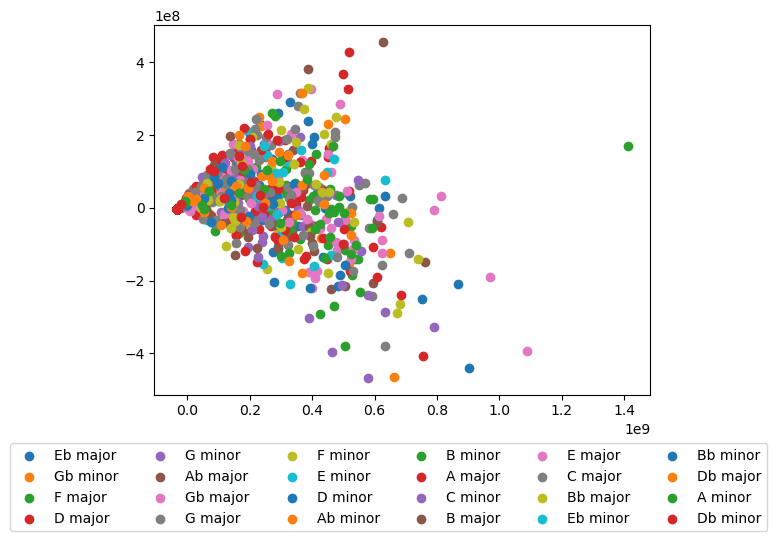

In [19]:
# PCA for initial visualization
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X_train)

transformed_df = pd.DataFrame(transformed_data, columns=["x", "y"])
transformed_df = transformed_df.join(y_train)

fig = plt.figure()
ax = fig.add_subplot()
for key in all_keys:
  samples = transformed_df[transformed_df["target"] == key]
  ax.scatter(x=samples["x"], y=samples["y"], label=key)
plt.legend(loc='right', bbox_to_anchor=(1.25, -0.25), ncol=6)

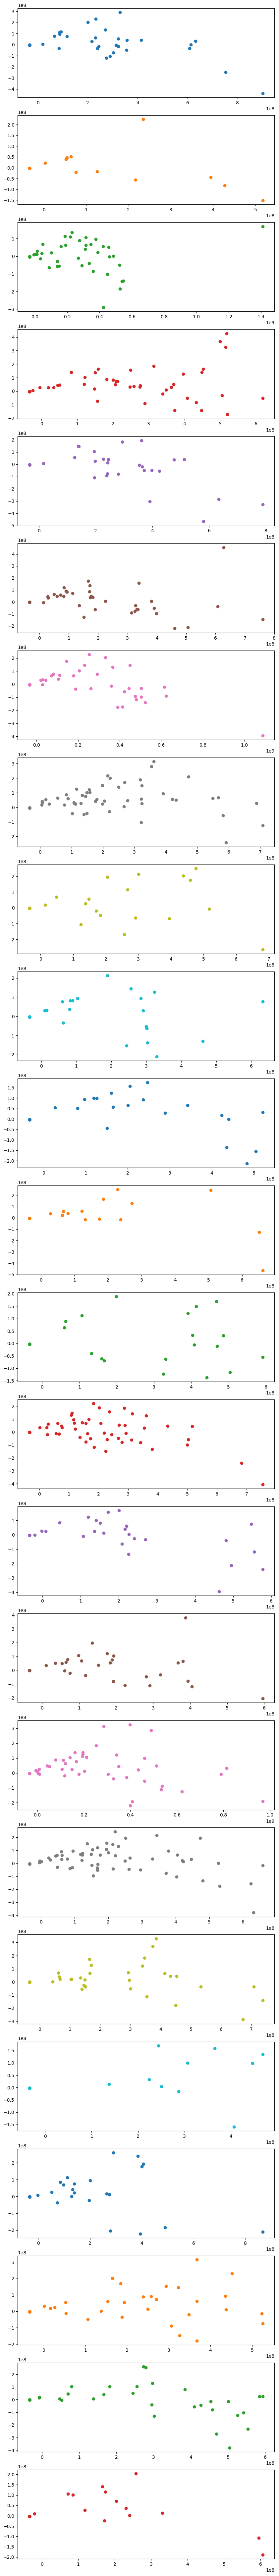

In [20]:
fig, axs = plt.subplots(len(all_keys), figsize=(10,100))
ax = 0
colors = plt.rcParams["axes.prop_cycle"]()

for key in all_keys:
  c = next(colors)["color"]
  samples = transformed_df[transformed_df["target"] == key]
  axs[ax].scatter(x=samples["x"], y=samples["y"], color=c, label=key)
  ax += 1
plt.show()

In [28]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_results = log_reg.predict(X_test)

def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=log_reg_results)
print(conf_matrix)
conf_matrix_to_df(conf_matrix, all_keys)

Text(0.5, 1.0, 'Confusion Matrix Heat Map')

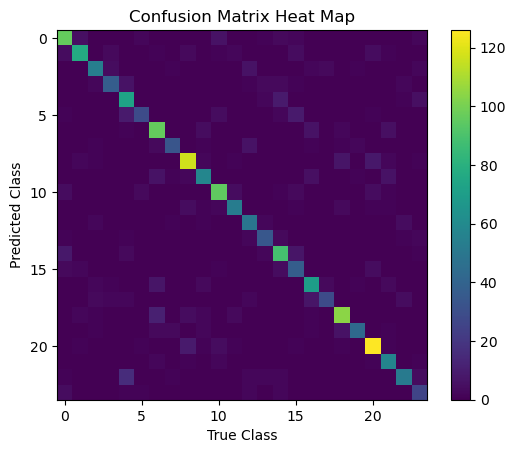

In [22]:
plt.imshow(conf_matrix)
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")

In [23]:
print(classification_report(y_true=y_test, y_pred=log_reg_results))

              precision    recall  f1-score   support

     A major       0.79      0.82      0.80       117
     A minor       0.87      0.77      0.81       100
    Ab major       0.81      0.74      0.77        73
    Ab minor       0.79      0.67      0.73        55
     B major       0.65      0.81      0.72        90
     B minor       0.81      0.53      0.64        55
    Bb major       0.74      0.84      0.79       114
    Bb minor       0.82      0.69      0.75        48
     C major       0.84      0.83      0.83       141
     C minor       0.77      0.73      0.75        79
     D major       0.83      0.83      0.83       115
     D minor       0.83      0.80      0.82        66
    Db major       0.70      0.83      0.76        59
    Db minor       0.74      0.77      0.76        44
     E major       0.75      0.81      0.78       110
     E minor       0.57      0.73      0.64        51
    Eb major       0.75      0.78      0.77        90
    Eb minor       0.83    

In [24]:
svm = SVC(kernel="poly", C=10)
svm.fit(X_train, y_train)
svm_results = svm.predict(X_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=svm_results)
conf_matrix_to_df(conf_matrix, all_keys)


,Eb major,Gb minor,F major,D major,G minor,Ab major,Gb major,G major,F minor,E minor,...,C minor,B major,E major,C major,Bb major,Eb minor,Bb minor,Db major,A minor,Db minor
Eb major,4,1,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,105,0,0,1
Gb minor,1,1,0,1,0,1,0,0,0,0,...,0,1,0,2,0,1,87,0,0,0
F major,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,71,0,0,0
D major,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,52,0,0,0
G minor,0,0,1,0,1,0,0,0,0,0,...,0,0,0,2,0,0,84,0,0,0
Ab major,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,52,0,0,0
Gb major,0,0,0,1,0,0,5,2,0,0,...,0,0,0,4,0,0,99,0,0,0
G major,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,47,0,0,0
F minor,0,0,0,0,0,0,0,0,7,0,...,0,1,0,3,0,6,119,0,0,0
E minor,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,74,0,0,0


Text(0.5, 1.0, 'Confusion Matrix Heat Map')

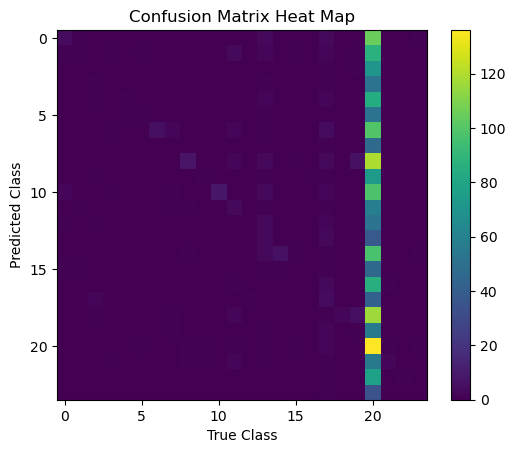

In [25]:
plt.imshow(conf_matrix)
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")

In [27]:
print(classification_report(y_true=y_test, y_pred=svm_results))

              precision    recall  f1-score   support

     A major       0.44      0.03      0.06       117
     A minor       0.25      0.01      0.02       100
    Ab major       0.00      0.00      0.00        73
    Ab minor       0.00      0.00      0.00        55
     B major       0.50      0.01      0.02        90
     B minor       0.33      0.02      0.03        55
    Bb major       1.00      0.04      0.08       114
    Bb minor       0.00      0.00      0.00        48
     C major       0.64      0.05      0.09       141
     C minor       0.33      0.01      0.02        79
     D major       1.00      0.07      0.13       115
     D minor       0.19      0.05      0.07        66
    Db major       0.00      0.00      0.00        59
    Db minor       0.10      0.07      0.08        44
     E major       0.86      0.05      0.10       110
     E minor       0.00      0.00      0.00        51
    Eb major       0.00      0.00      0.00        90
    Eb minor       0.09    